## OLS on Nelson Siegel parametrization of US treasury yield curve

**Motivation** </br>

One challenge with modeling the yield curve is that it consists of many maturities (1m, 3m...30y). The high dimensionality makes it somewhat cumbersome to make predictions on it. One may decide to select a set of features and attempt to fit a model for each of the maturities, but some issues are:

- Separate predictions do not account for the structure of the yield curve. It is clear that the yields of different maturities are correlated in some way
- Predicted yields might not make sense (negative values, weird yield curve structures)

**Possible solution**

The Nelson Siegel model parametrizes the yield curve using 3 parameters: $\beta_1$, $\beta_2$, $\beta_3$. You may think of them as the level, slope, and "twist/curvature" of the yield curve. Now, instead of having to predict over 10 maturities, we only need to predict 3 values. The hyperparameter $\lambda$ controls the curvature/shape of the parametrized curve

$$y(\tau) = \beta_0 + \beta_1 \left( \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} \right) + \beta_2 \left( \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda} \right)
$$

**Explanation of variables**:
- $y(\tau)$: The yield (interest rate) at a given maturity $ \tau $.
- $ \tau $: The time to maturity of the bond (years)
- $ \beta_0 $: The long-term level of interest rates (as $ \tau \to \infty $).
- $ \beta_1 $: The short-term component, influencing the curve's initial level.
- $ \beta_2 $: The medium-term component, controlling the hump or curvature.
- $ \lambda $: The decay factor that determines how quickly the effects of $ \beta_1 $ and $ \beta_2 $ fade over time.

**Intuition**:
- $ \beta_0 $ shifts the entire curve up or down.
- $ \beta_1 $ controls the slope of the curve at shorter maturities.
- $ \beta_2 $ determines the convexity or "hump" shape of the yield curve.
- $ \lambda $ controls how quickly the short-term and medium-term effects decay.


Of course, by reducing the dimensionality of the problem, we also lose some accuracy/information on the original yield curve. We will explore if such a tradeoff is worth it




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import stats

### Problem setup

#### Load data

1. Gather yield curve data
2. Back out Nelson Siegel parameters (set $\lambda = 1.6729$)
3. Gather macroeconomic predictors (I chose PCE, UMC consumer sentiment, unemploymet rate)
4. Resample to 1 months and then take the difference
5. Shift responses forward 1 month (Use last month's change in macro variables to predict next month's change in response variables)

#### OLS model: Train and predict

Training period: 2010-01 to 2022-12 </br> Test period: 2023-01 to 2024-12

**Method 1:** Fit and predict for each of the 10 yield curve maturities directly </br>
**Method 2:** Fit and predict for 3 Nelson Siegel parameters then transform back

Note: We are regressing the *monthly change* in our macro predictors on the *next-monthly change* in the responses

#### Compare methods

Compare the sum of the absolute error of the predicted vs actual yield curve values for each maturity (then take mean over each of the 24 months in test period). If we let $T = \{\tau_1, \tau_2...\tau_n \}$ be the set of maturities in the yield curve in years ($1/12, 3/12...30$), then we are comparing

$$L_{t} = \sum_{\tau \in T} | y_{\tau} - \hat{y}_{\tau}|$$ and then $$L = \frac{1}{n}\sum_{i=1}^{n}L_{t_i}$$ for both methods where $n$ is the number of test samples. We can perform a 2-sample t-test to see if there is a statistical significant difference in the 2 methods. We also will qualitatively examine the visual plot of the true yield curve vs predicted yield curve for both methods

### Load data

- Download csv from fed: https://home.treasury.gov/interest-rates-data-csv-archive
- Maturities: 1m, 3m, 6m, 1y, 2y, 3y, 5y, 7y, 10y, 30y

In [2]:
# cutoff dates for dataset + train/test split
start_cutoff_date = pd.Timestamp('2010-01-01')
test_cutoff_date = pd.Timestamp("2023-01-01")

In [3]:
df = pd.read_csv("yield-curve-rates-1990-2024.csv")

# Select these 10 maturities
maturity_labels = ['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '30 Yr']
cols = ['Date'] + maturity_labels 
df = df[cols]

# Transform date column
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df = df[df.Date >= start_cutoff_date]

# Remove nan rows
df = df[~df.isna().any(axis = 1)]
df = df.set_index("Date")

# new start cutoff date
start_cutoff_date = df.index[-1]

# Make sure no big gaps in data
day_gaps = np.abs(df.index.to_series().diff().dt.days)
assert not (day_gaps >= 5).any(), "There are missing days in the data"

print("Data starts at:", start_cutoff_date)

Data starts at: 2010-01-04 00:00:00


#### Nelson siegel parameter fitting

Because macro predictors are monthly, we need to resample yield curve values to monthly as well

In [4]:
# Convert maturity labels to # years

def maturity_label_to_float(m_string):
    number = int(m_string[:2])
    suffix = m_string[-2:]

    assert suffix in {"Mo", "Yr"}, "label must be either 'Mo' or 'Yr'"

    if suffix == 'Mo':
        return number/12

    elif suffix == 'Yr':
        return number

T = [maturity_label_to_float(m) for m in maturity_labels]        

In [5]:
# Terms in Nelson Siegel equation
def term2(tau, lam):
    num = 1 - np.exp(-tau/lam)
    denom = tau/lam

    res = num/denom
    return res

def term3(tau, lam):
    res = term2(tau, lam) - np.exp(-tau/lam)
    return res

# Construct i-th row of X matrix
def X_row(T, i, lam):
    return [1, term2(T[i], lam), term3(T[i], lam)]


def B_t(y_t, lam = 1.6729):
    assert len(T) == len(y_t), "must have same # of yield curve values as maturities"

    X = [X_row(T, i, lam) for i in range(len(T))]
    X = np.array(X)

    B = (np.linalg.inv(X.T @ X) @ X.T) @ y_t
    return B

#### Quick glance at Nelson Siegel parameters

In [6]:
beta_labels = ['beta1', 'beta2', 'beta3']
df[beta_labels] =  df.apply(B_t, axis=1).apply(pd.Series)

df = df.iloc[::-1]
df.head(3)

1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  30 Yr  \
Date                                                                       
2010-01-04  0.05  0.08  0.18  0.45  1.09  1.66  2.65  3.36   3.85   4.65   
2010-01-05  0.03  0.07  0.17  0.41  1.01  1.57  2.56  3.28   3.77   4.59   
2010-01-06  0.03  0.06  0.15  0.40  1.01  1.60  2.60  3.33   3.85   4.70   

               beta1     beta2     beta3  
Date                                      
2010-01-04  5.275659 -5.343255 -3.623379  
2010-01-05  5.219653 -5.283081 -3.812100  
2010-01-06  5.345147 -5.416863 -3.970436

In [7]:
df_resampled = df.resample('MS').first()

expected_dates = pd.date_range(start=df_resampled.index.min(), end=df_resampled.index.max(), freq='MS')  # 'MS' = Month Start
missing_dates = expected_dates.difference(df_resampled.index)

assert len(missing_dates) == 0, "There are missing months in df_resampled"

In [8]:
yield_curves = df_resampled.iloc[:, :-3]
betas = df_resampled.iloc[:, -3:]

### Part 2: Load macroeconomic variable data

#### Load macroeconomic data

- PCE: https://fred.stlouisfed.org/series/PCEPI
- Unemployment Rate: https://fred.stlouisfed.org/series/UNRATE
- Consumer sentiment: https://fred.stlouisfed.org/series/UMCSENT


In [9]:
from functools import reduce

pce = pd.read_csv("PCEPI_max.csv")
sent = pd.read_csv("UMCSENT_max.csv")
unemp = pd.read_csv("UNRATE_max.csv")

pce['observation_date'] = pd.to_datetime(pce['observation_date'])
sent['observation_date'] = pd.to_datetime(sent['observation_date'])
unemp['observation_date'] = pd.to_datetime(unemp['observation_date'])

pce = pce[pce.observation_date >= start_cutoff_date]
sent = sent[sent.observation_date >= start_cutoff_date]
unemp = unemp[unemp.observation_date >= start_cutoff_date]

assert not pce.isnull().values.any(), "pce df has nan values"
assert not sent.isnull().values.any(), "sent df has nan values"
assert not unemp.isnull().values.any(), "unemp df has nan values"

features = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='outer'), [pce, sent, unemp])

# features['observation_date'] = pd.to_datetime(features['observation_date'])
features = features.rename(columns = {'observation_date': 'Date'})
features = features.iloc[::-1].reset_index(drop = True)
features = features.set_index("Date")

features = features.iloc[::-1]

#### Merge features with responses

- Take the diff of predictors/response to stationarize data
- Shift responses such that we use last month's change in predictor to predict next month's change in response.

In [10]:
yc_values = pd.merge(features, yield_curves, left_index=True, right_index=True)
B_values =  pd.merge(features, betas, left_index=True, right_index=True)

In [11]:
yc = yc_values.diff()
B = B_values.diff()

# Shift maturity changes: e.g. 02-01 means change in yields from 02-01 to 03-01
yc[maturity_labels] = yc[maturity_labels].shift(-1)
B[beta_labels] = B[beta_labels].shift(-1)

yc = yc.iloc[1:]
B = B.iloc[1:]

#### Preview of data to be used in OLS train/test

In [12]:
yc.head(3)

PCEPI  UMCSENT  UNRATE  1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  \
Date                                                                           
2010-03-01  0.127      0.0     0.1  0.07  0.03  0.05  0.10  0.25  0.29  0.31   
2010-04-01  0.049     -1.4     0.0 -0.02  0.01  0.01  0.01 -0.05 -0.07 -0.12   
2010-05-01  0.029      1.4    -0.3  0.00 -0.01 -0.02 -0.08 -0.22 -0.30 -0.38   

            7 Yr  10 Yr  30 Yr  
Date                            
2010-03-01  0.28   0.28   0.18  
2010-04-01 -0.16  -0.17  -0.21  
2010-05-01 -0.42  -0.43  -0.34

In [13]:
B.head(3)

PCEPI  UMCSENT  UNRATE     beta1     beta2     beta3
Date                                                            
2010-03-01  0.127      0.0     0.1  0.190138 -0.205649  0.609067
2010-04-01  0.049     -1.4     0.0 -0.246322  0.254903  0.194035
2010-05-01  0.029      1.4    -0.3 -0.403277  0.466952 -0.389237

#### Stationarity check

In [14]:
def plot_ts(ax, df, col):
    ax.plot(df.index, df[col], label= col)
    ax.grid(True)
    ax.legend()
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='x', rotation=45)

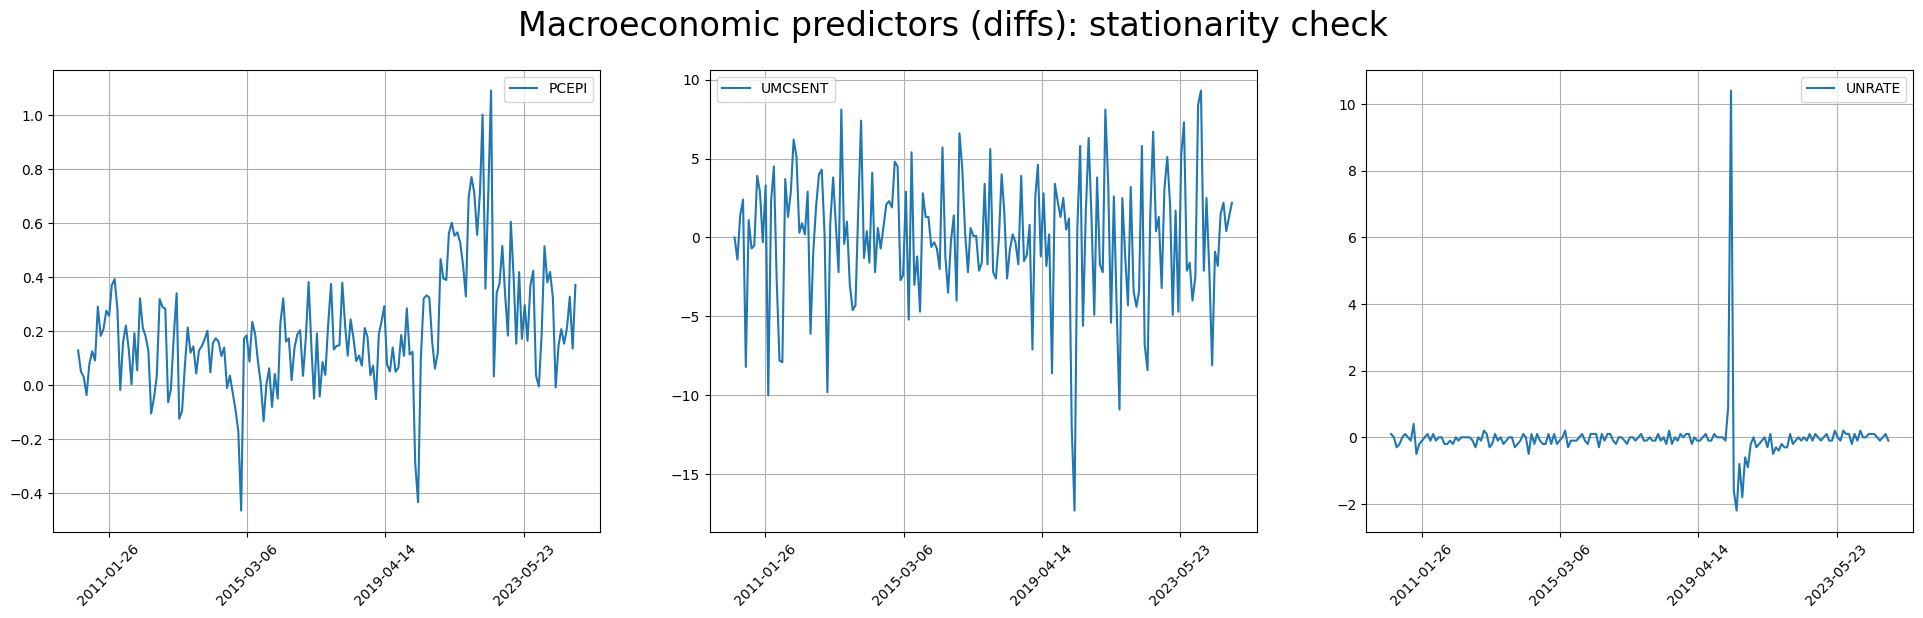

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Macroeconomic predictors (diffs): stationarity check', fontsize=24)

cols = B.columns[:3]
for i, c in enumerate(cols):
    plot_ts(axs[i], B, c)

plt.show()

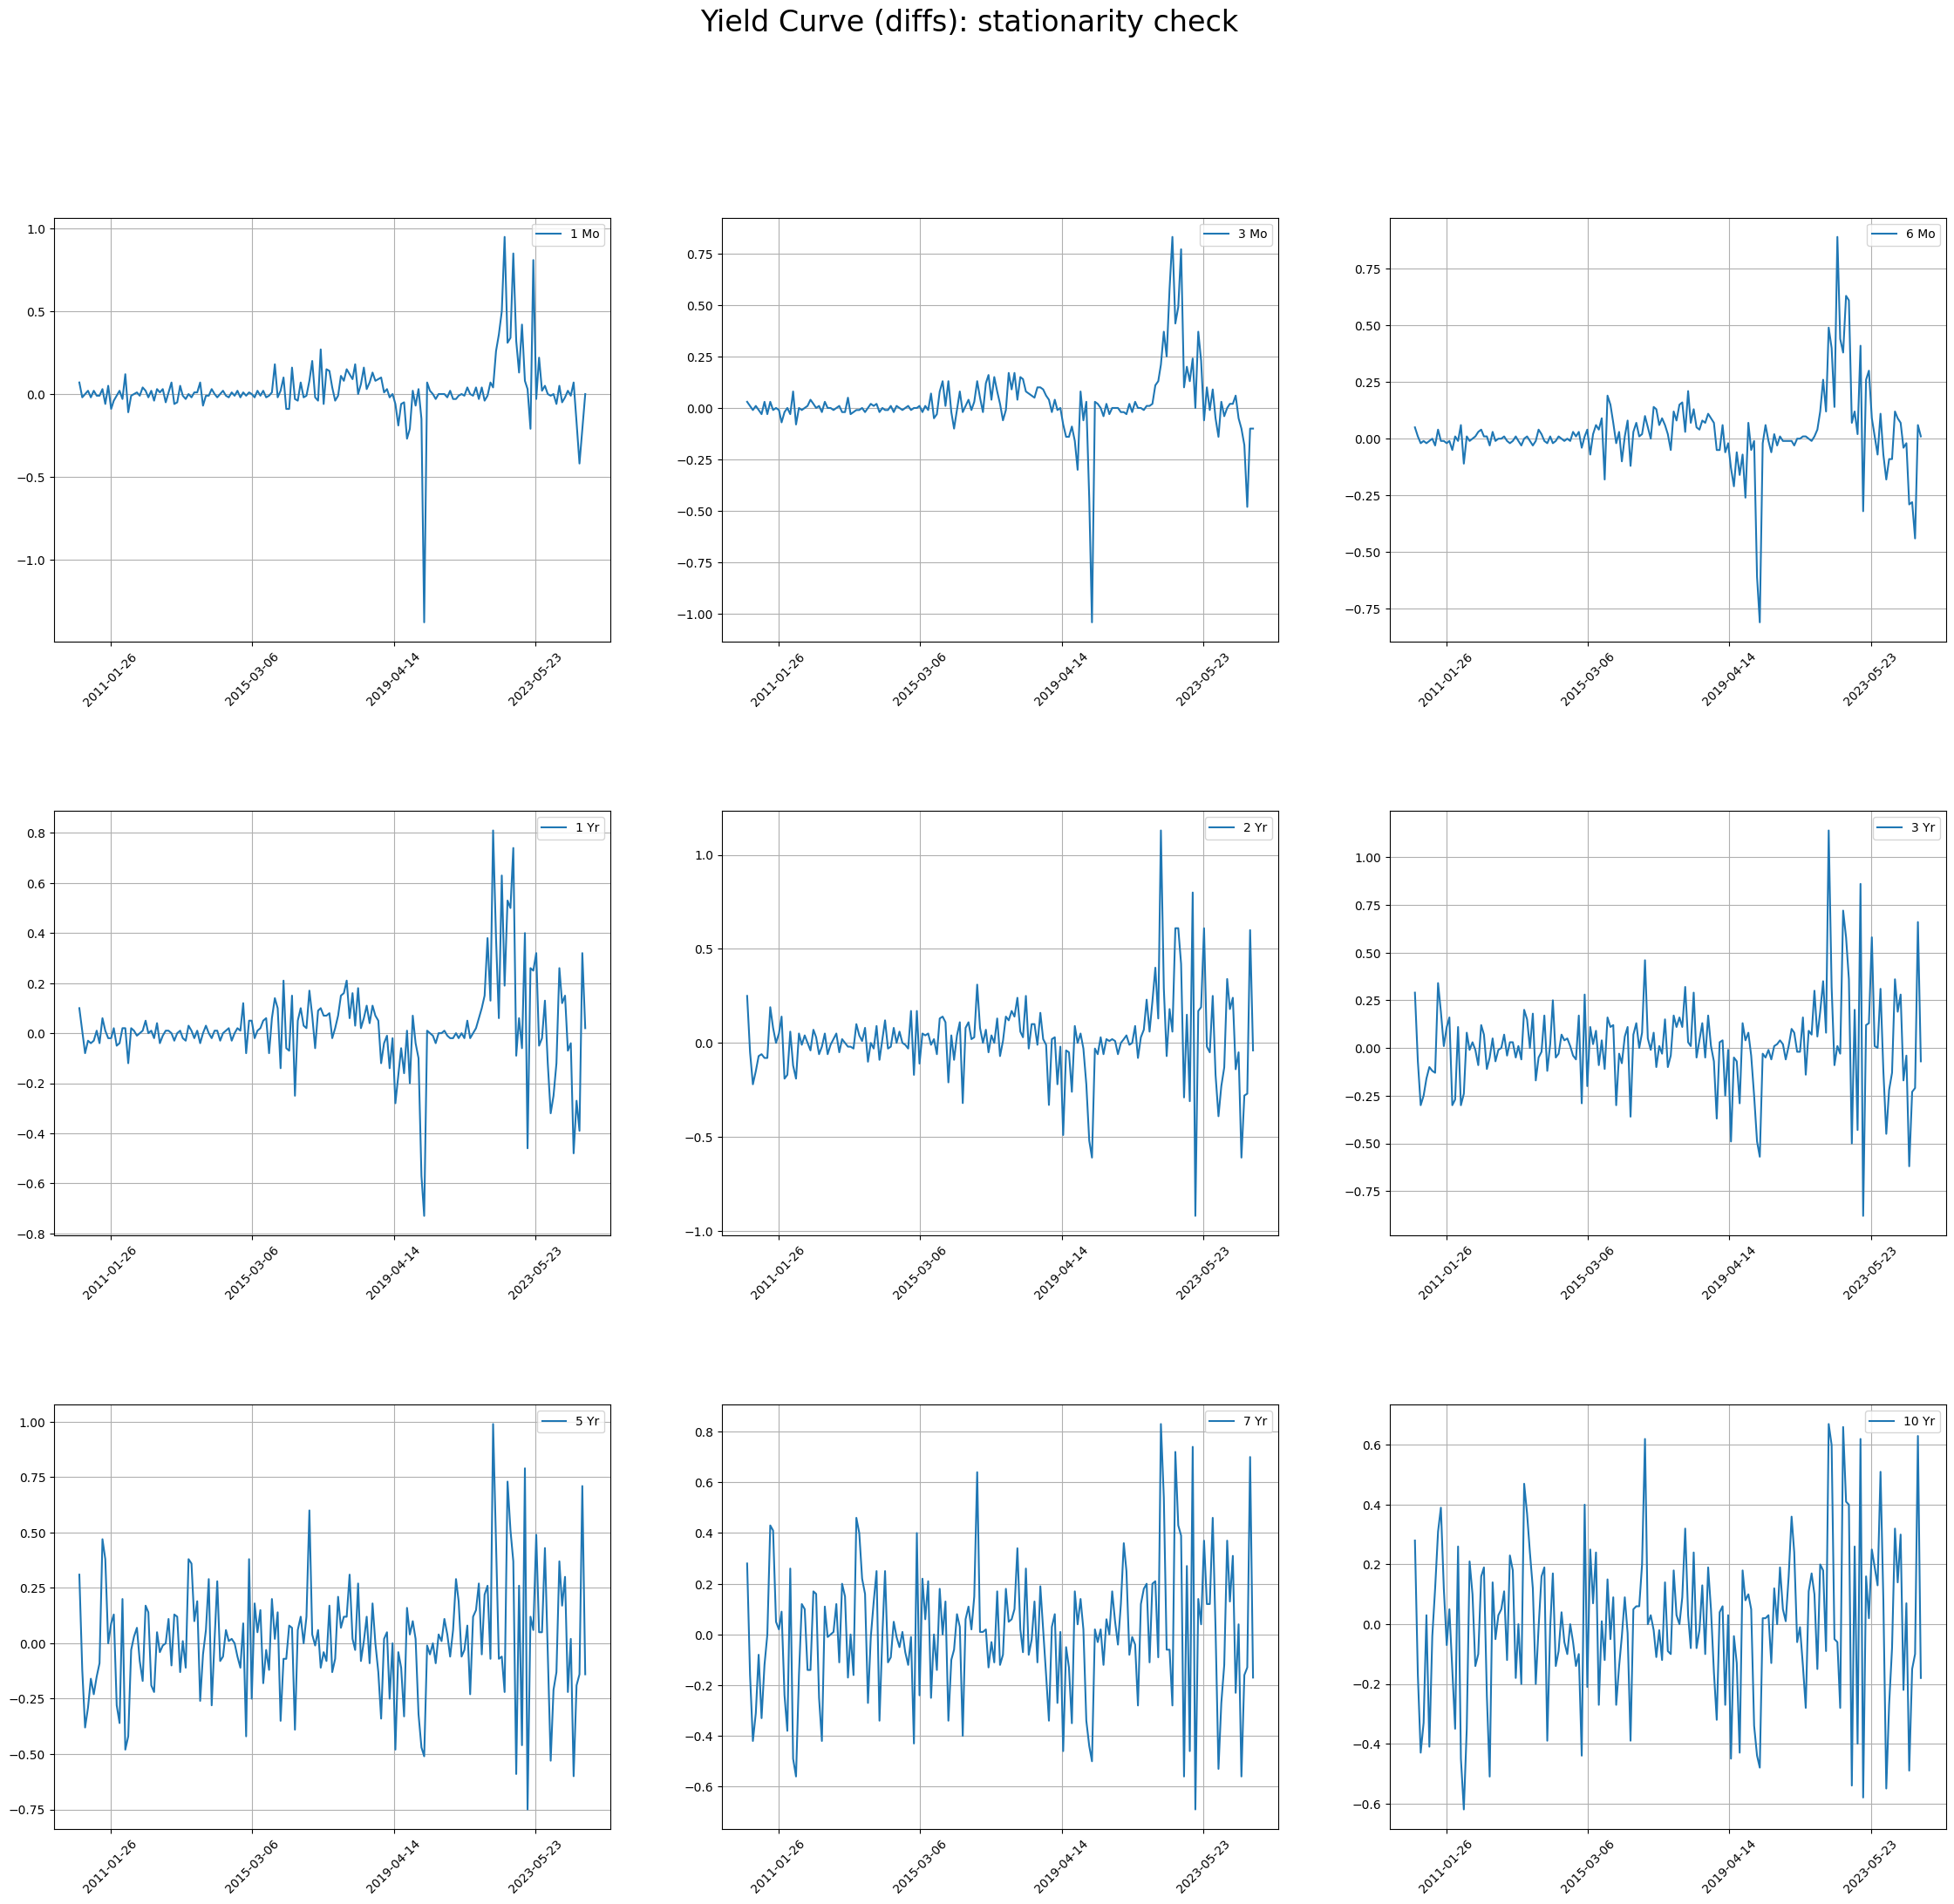

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(28, 24))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Yield Curve (diffs): stationarity check', fontsize=24)

cols = yc.columns[3:-1]
for i, c in enumerate(cols):
    plot_ts(axs[i//3, i%3], yc, c)

plt.show()

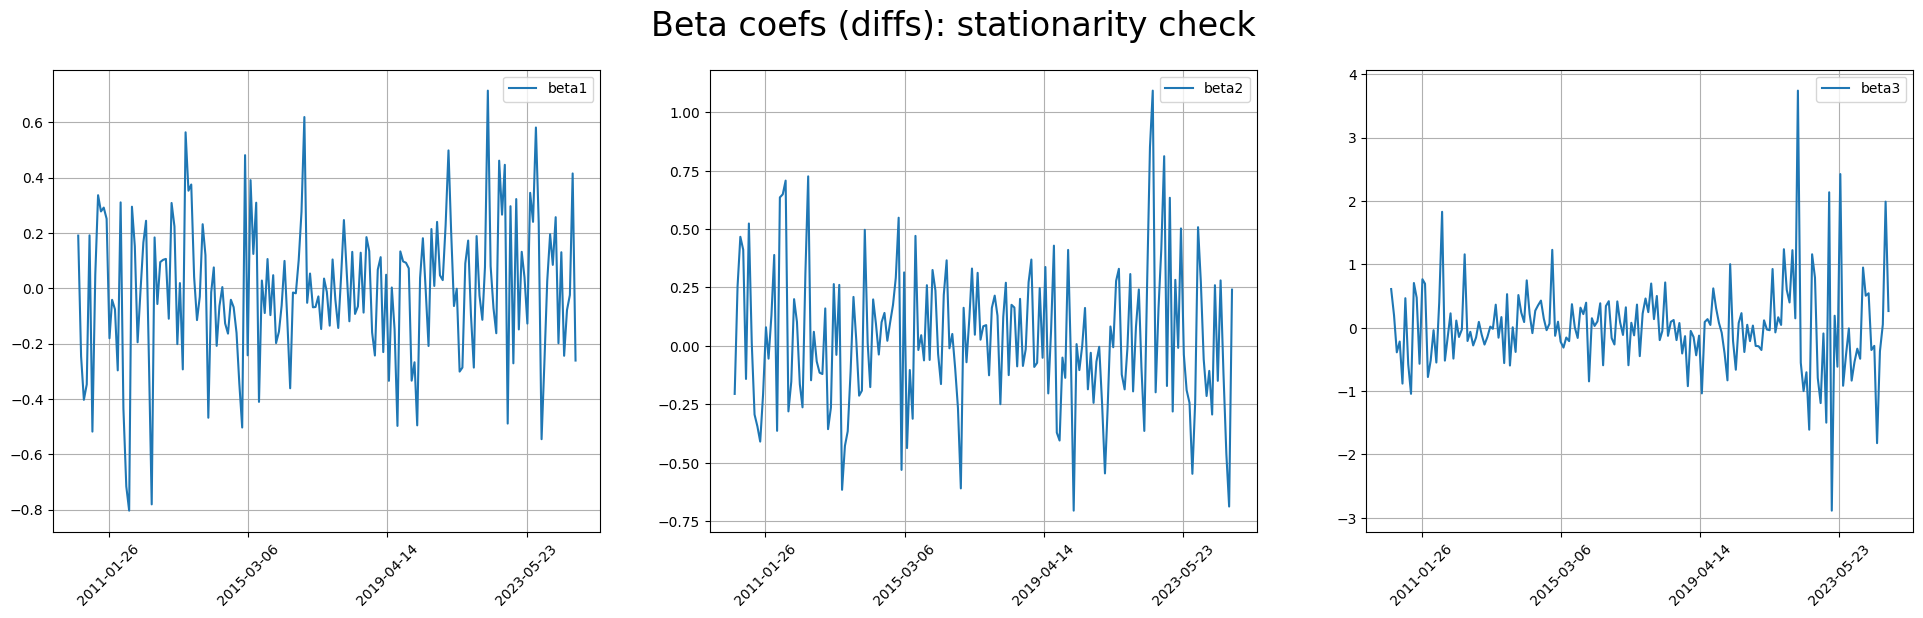

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Beta coefs (diffs): stationarity check', fontsize=24)

cols = B.columns[3:]
for i, c in enumerate(cols):
    plot_ts(axs[i], B, c)

plt.show()

###  Part 3: Regress macroeconomic variables

**What is it we're actually performing OLS on?** </br>

We are regressing the *monthly change* in our macro predictors on the *next-month change* in the yields of each maturity. Note that we are not performing OLS on the macro features or yield curve values themselves, because it would be incorrect to perform OLS on non-stationary data (leading to spurious correlation and unmeaningful results). </br>

Also note that we are using the past to predict the future. We are using the change in macro predictor values from last month to predict the changes in yield curve for next month. *In practice, if we want to predict the change in yield curve for next month, we don't know the change in macro predictors of next month*

**What does the model assume?** </br>

- There is a linear relationship between *monthly changes* in macro predictors and the *next-month change* in yields of each maturity
- This relationship remains the same across time

Obviously, such assumptions are very rough approximations of reality and are not meant to be correct. However, linear regression can still serve as a rough approximation for the relationship between our chosen predictors and responses

#### Train test split

In [18]:
import statsmodels.api as sm

def train_test_split(df, cutoff_date):
    df_train = df[df.index < cutoff_date]
    df_test = df[df.index >= cutoff_date]
    
    X_train = df_train.iloc[:, :3]
    Y_train = df_train.iloc[:, 3:]
    
    X_train = sm.add_constant(X_train)
    
    X_test = df_test.iloc[:, :3]
    Y_test = df_test.iloc[:, 3:]
    
    X_test = sm.add_constant(X_test)

    return X_train, Y_train, X_test, Y_test

X_train_yc, Y_train_yc, X_test_yc, Y_test_yc = train_test_split(yc, test_cutoff_date)
X_train_B, Y_train_B, X_test_B, Y_test_B = train_test_split(B, test_cutoff_date)

#### Fit OLS on each maturity of yield curve

In [19]:
def ols(X_train, Y_train, X_test, Y_test, col):
    # Get current maturity
    y = Y_train[[col]]

    # Fit
    sm_model = sm.OLS(y, X_train).fit()
    summary = sm_model.summary2().tables[1]

    fitted_values = sm_model.fittedvalues  # ŷ (predictions on training data)
    residuals = sm_model.resid  # y - ŷ (errors on training data)

    train_result = pd.DataFrame({'pred': fitted_values, 'residual': residuals})

    # Predict
    result = pd.DataFrame(sm_model.predict(X_test), columns = ["pred"])
    result['truth'] = Y_test[col]
    result['residual'] = result['truth'] - result['pred']
    
    return train_result, summary, result, sm_model

In [20]:
# Get results for each maturity
maturities = Y_train_yc.columns
train_res_yc, summaries_yc, results_yc, direct_ols_models = zip(*[ols(X_train_yc, Y_train_yc, X_test_yc, Y_test_yc, col) for col in maturities])

In [21]:
# aggregate residuals of each maturity into 1 df 
all_residuals_yc = pd.concat([res["residual"] for res in results_yc], axis=1)
all_residuals_yc.columns = maturities
all_residuals_yc['total_abs_error'] = all_residuals_yc.abs().sum(axis=1)

# same for predictions
all_preds_yc = pd.concat([res["pred"] for res in results_yc], axis=1)
all_preds_yc.columns = maturities

all_residuals_yc.head()

1 Mo      3 Mo      6 Mo      1 Yr      2 Yr      3 Yr  \
Date                                                                     
2023-01-01  0.252768 -0.041174 -0.176642 -0.268500 -0.527862 -0.661761   
2023-02-01 -0.015518  0.140994  0.296720  0.281056  0.679930  0.736253   
2023-03-01  0.054403  0.015800 -0.312657 -0.445189 -0.889451 -0.829077   
2023-04-01 -0.302951  0.272135  0.145169  0.140914  0.050425 -0.001207   
2023-05-01  0.821013  0.232976  0.293678  0.248440  0.203317  0.161082   

                5 Yr      7 Yr     10 Yr     30 Yr  total_abs_error  
Date                                                                 
2023-01-01 -0.699838 -0.687825 -0.608918 -0.485877         4.411165  
2023-02-01  0.666974  0.625596  0.517221  0.346036         4.306298  
2023-03-01 -0.675144 -0.610720 -0.503390 -0.270945         4.606777  
2023-04-01  0.001870  0.030788  0.061397  0.127571         1.134426  
2023-05-01  0.112542  0.097300  0.076799  0.045241         2.292388

**OLS training summaries on select maturities**

Interpretation: What is the avg next-month change in the 3 Mo yield for a previous-month change of 1% in PCE, holding other variables constant?

In [22]:
print(f"OLS train summary for maturity: {maturities[1]}")
summaries_yc[1]

OLS train summary for maturity: 3 Mo


Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
const   -0.015085  0.016285 -0.926327  0.355764 -0.047263  0.017092
PCEPI    0.246544  0.058545  4.211203  0.000044  0.130865  0.362223
UMCSENT  0.007323  0.003264  2.243649  0.026320  0.000874  0.013772
UNRATE   0.023073  0.015513  1.487297  0.139035 -0.007580  0.053726

In [23]:
print(f"OLS train summary for maturity: {maturities[8]}")
summaries_yc[8]

OLS train summary for maturity: 10 Yr


Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
const   -0.055318  0.023912 -2.313380  0.022060 -0.102565 -0.008070
PCEPI    0.322734  0.085964  3.754314  0.000248  0.152878  0.492590
UMCSENT  0.013589  0.004792  2.835540  0.005207  0.004120  0.023058
UNRATE   0.037611  0.022779  1.651141  0.100802 -0.007398  0.082620

**Correlation matrix of features**

In [24]:
features_corr = X_train_yc[['PCEPI', 'UMCSENT', 'UNRATE']].corr()
features_corr

PCEPI   UMCSENT    UNRATE
PCEPI    1.000000 -0.002381 -0.263899
UMCSENT -0.002381  1.000000 -0.377702
UNRATE  -0.263899 -0.377702  1.000000

#### Interpretation

Looking at the p-values, we can conclude that there is some positive relationship between PCE (inflation)/consumer sentiment and yields. Conceptually, an increase in inflation/consumer sentiment in the previous month generally leads to rises in yields in the next month. This aligns with economic intuition, as the Fed will tend to raise rates to dampen inflation/overheated economy. Meanwhile, we do not find a statistically significant relationship between yields and unemployment (holding other variables constant). </br>

Because the correlation between unemployment and the other 2 features are somewhat high, we could have chosen to remove it to have a stronger interpretation of linear regression results. But since our primary goal is prediction, we will keep it for now 



#### Residuals vs fitted values

In [25]:
def plot_resid_vs_fitted(ax, results, plot_title):
    
    assert "pred" in results.columns, "pred must be a column in results"
    assert "residual" in results.columns, "residual must be a column in results"
    
    ax.scatter(results['pred'], results['residual'], alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')  # Reference line at zero
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    ax.set_title(plot_title)
    ax.grid(True)


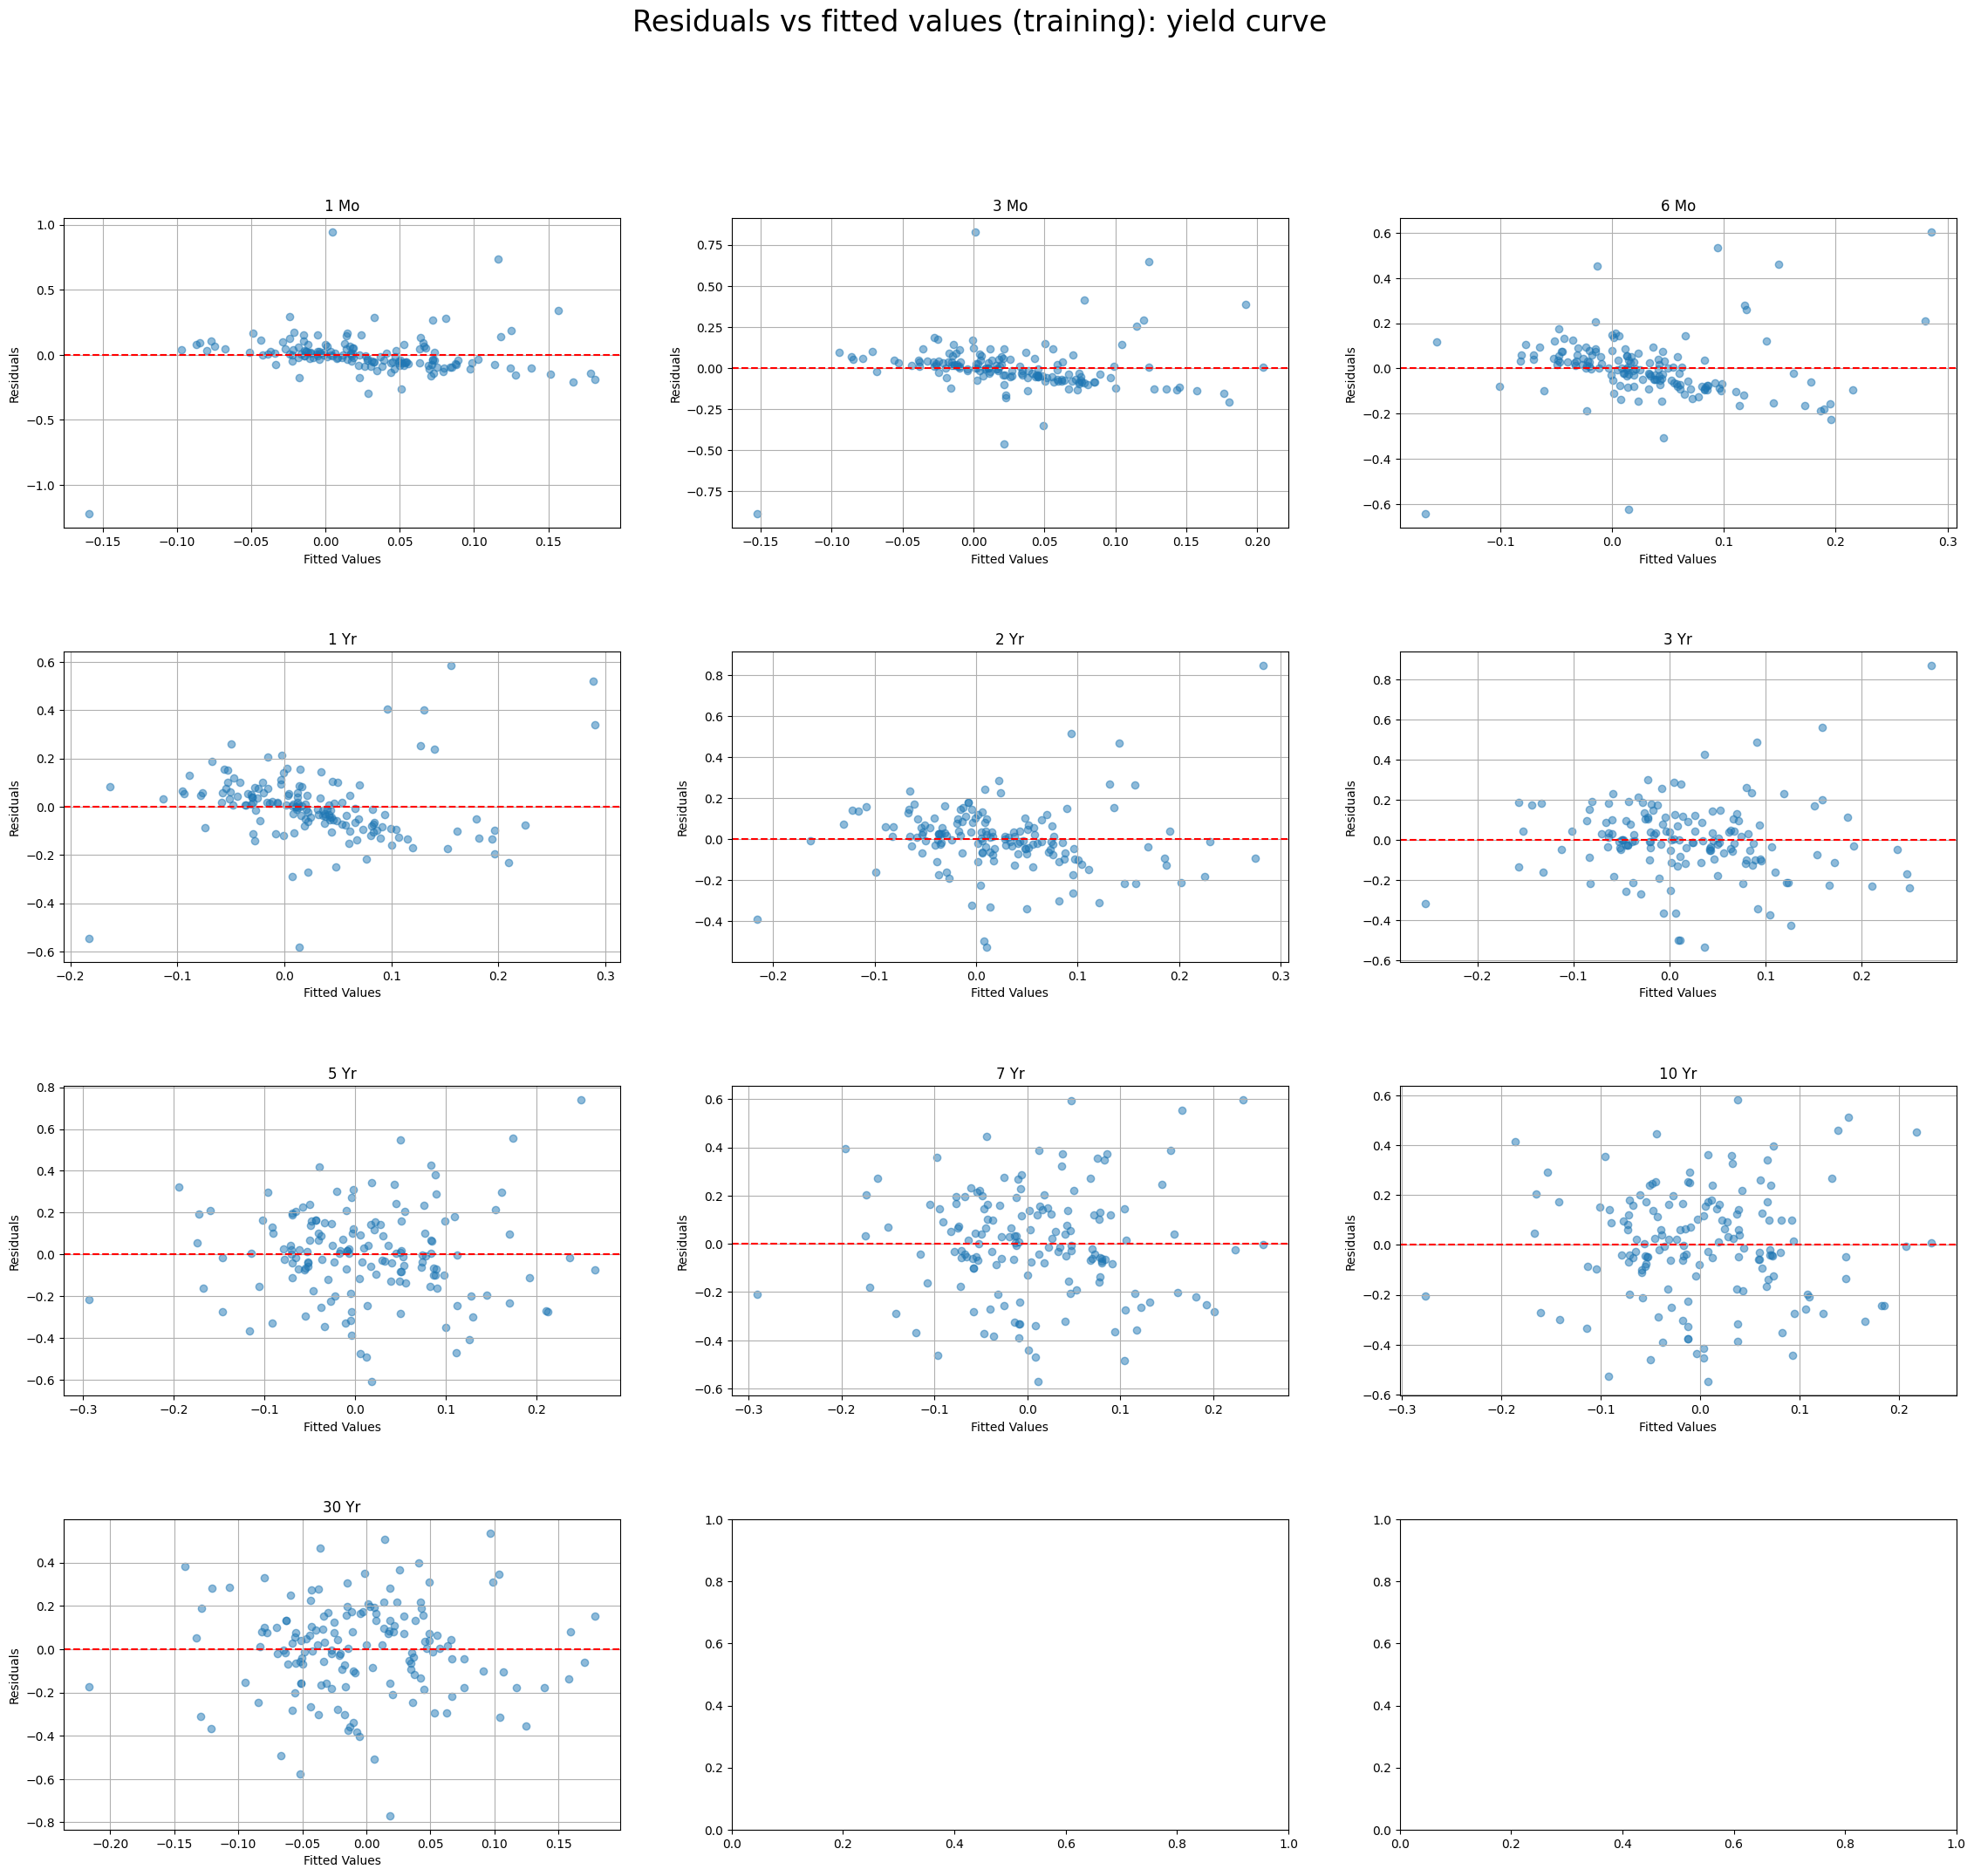

In [26]:
n = len(maturities)

fig, axs = plt.subplots(math.ceil(n/3), 3, figsize=(28, 24))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Residuals vs fitted values (training): yield curve', fontsize=24)

for i, c in enumerate(maturities):
    curr_result = train_res_yc[i]
    plot_resid_vs_fitted(axs[i//3, i%3], curr_result, c)

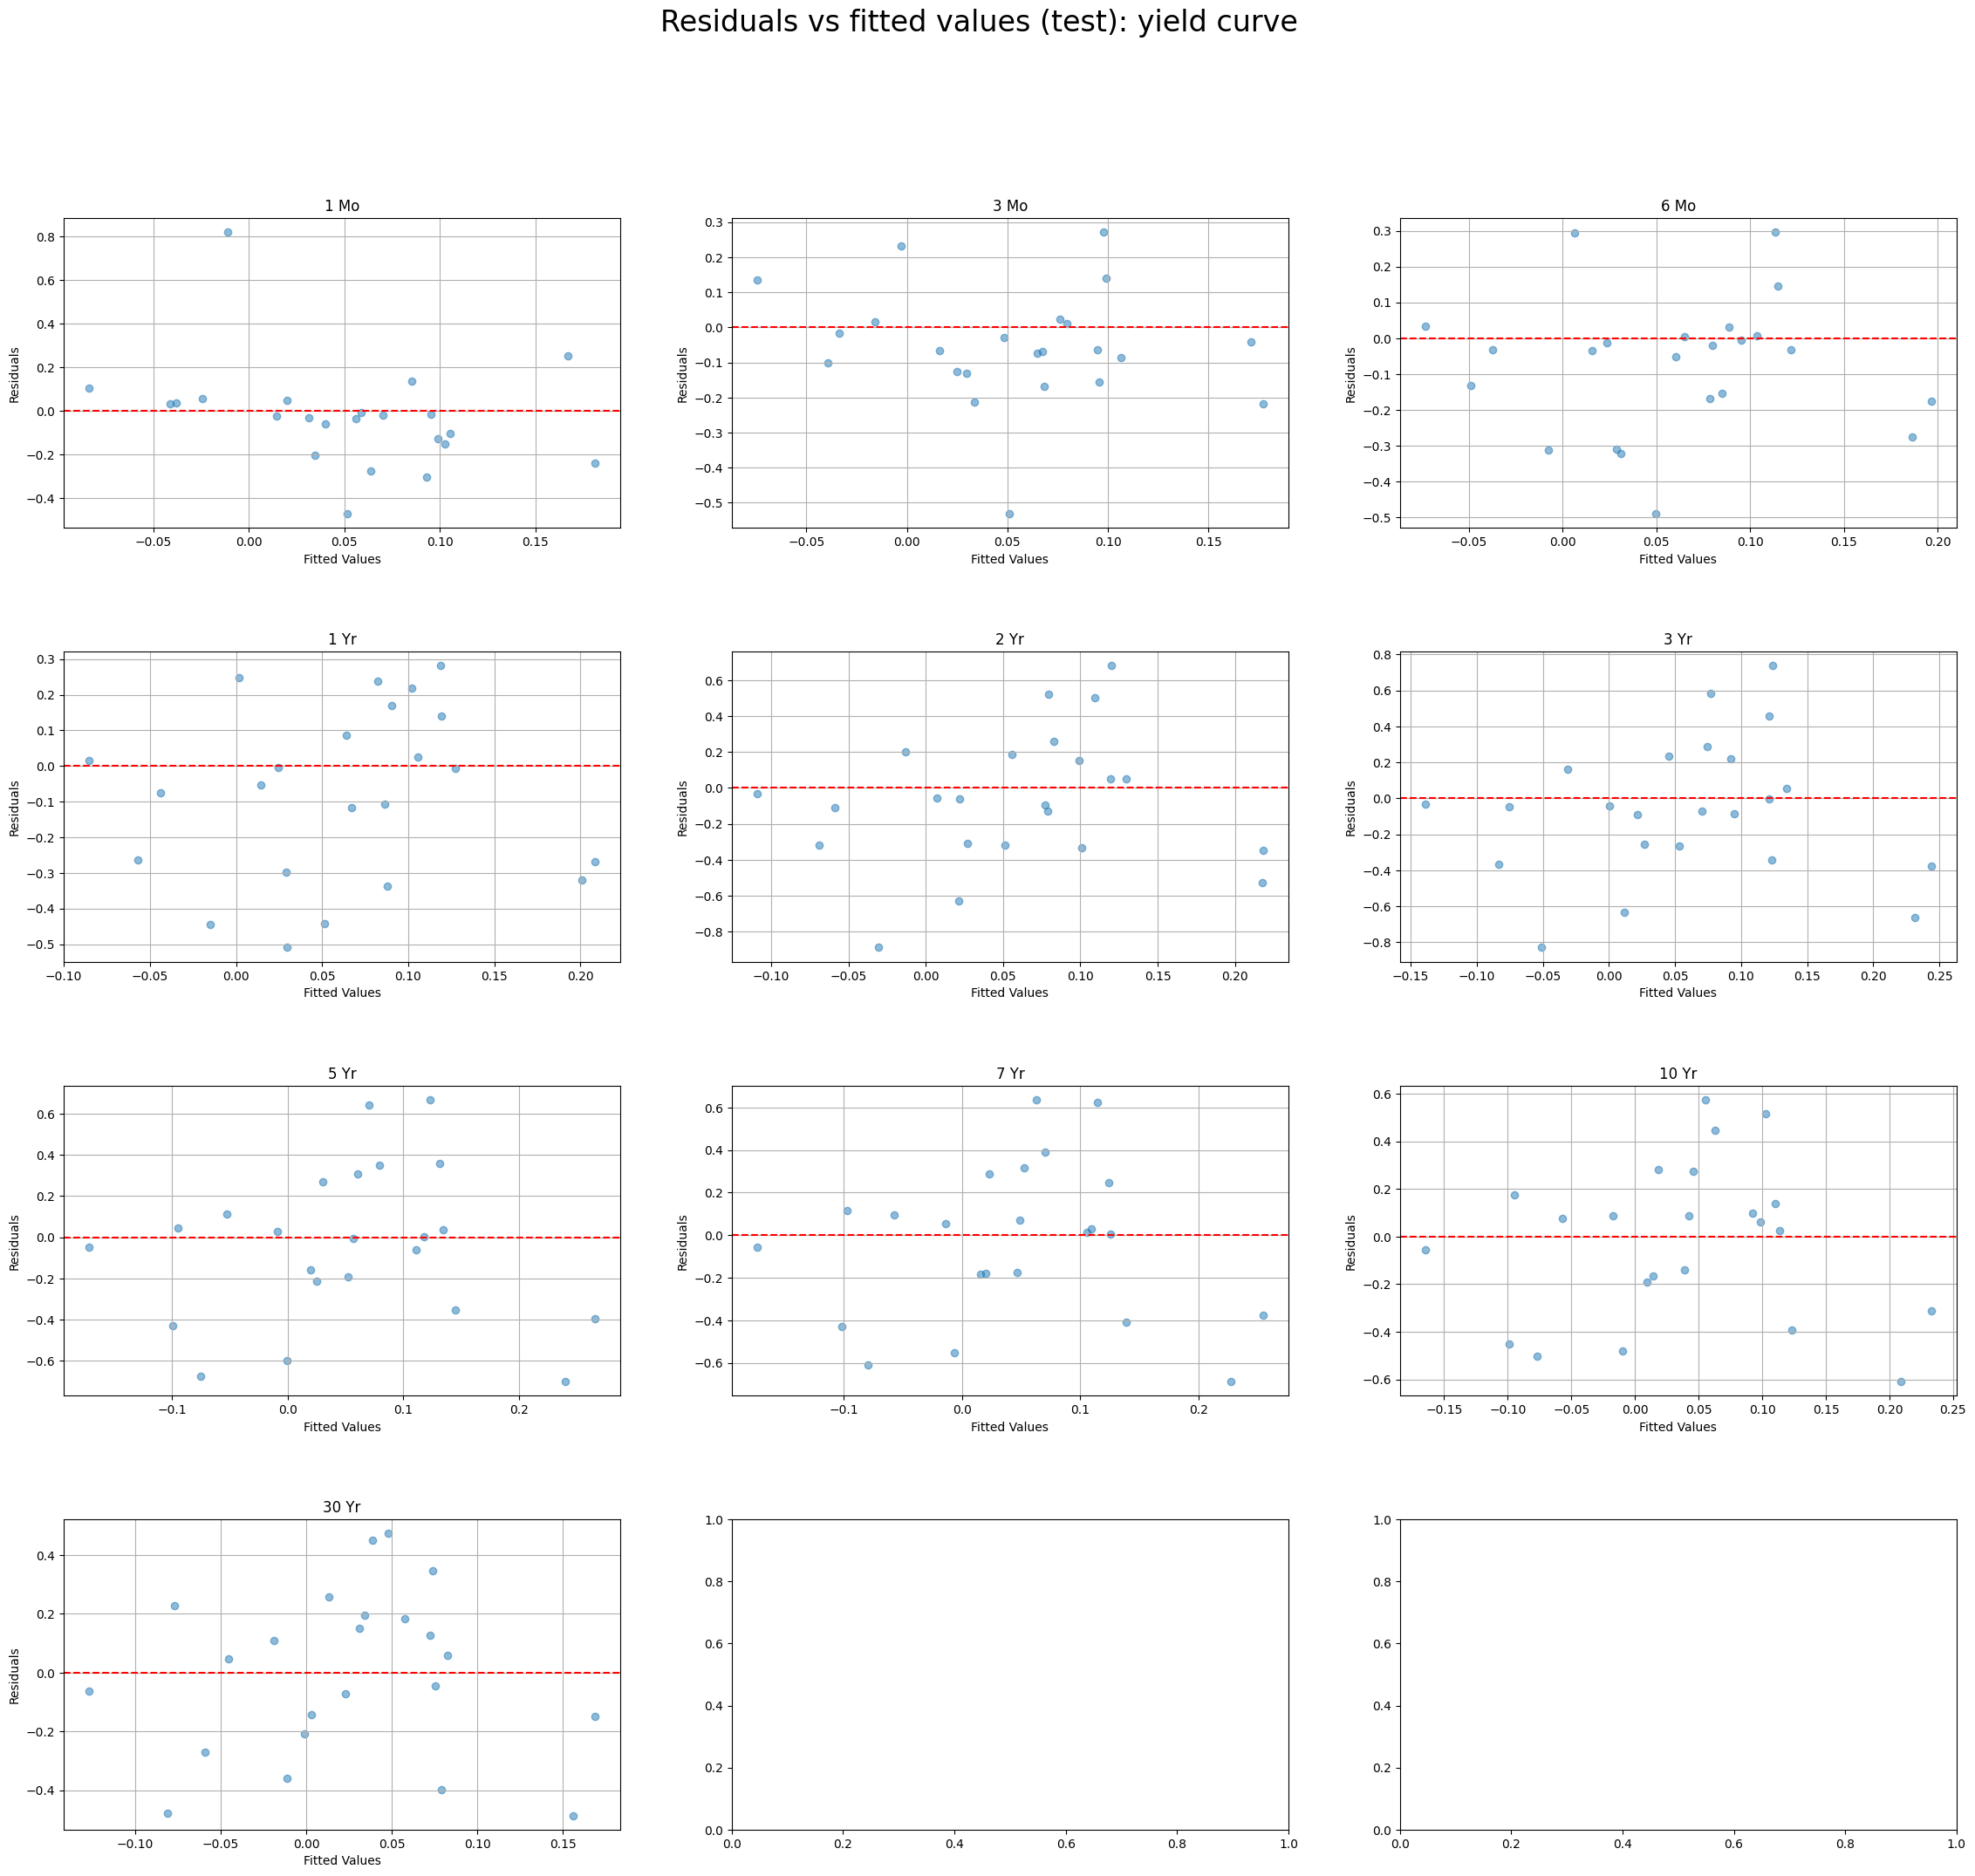

In [27]:
n = len(maturities)

fig, axs = plt.subplots(math.ceil(n/3), 3, figsize=(28, 24))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Residuals vs fitted values (test): yield curve', fontsize=24)

for i, c in enumerate(maturities):
    curr_result = results_yc[i]
    plot_resid_vs_fitted(axs[i//3, i%3], curr_result, c)

#### Fit OLS: Nelson Siegel parameters

In [28]:
beta_cols = Y_train_B.columns
train_res_B, summaries_B, results_B, ns_models = zip(*[ols(X_train_B, Y_train_B, X_test_B, Y_test_B, col) for col in beta_cols])

In [29]:
all_residuals_B = pd.concat([res["residual"] for res in results_B], axis=1)
all_residuals_B.columns = beta_cols

all_preds_B = pd.concat([res["pred"] for res in results_B], axis=1)
all_preds_B.columns = ["pred_change_" + b for b in beta_cols]

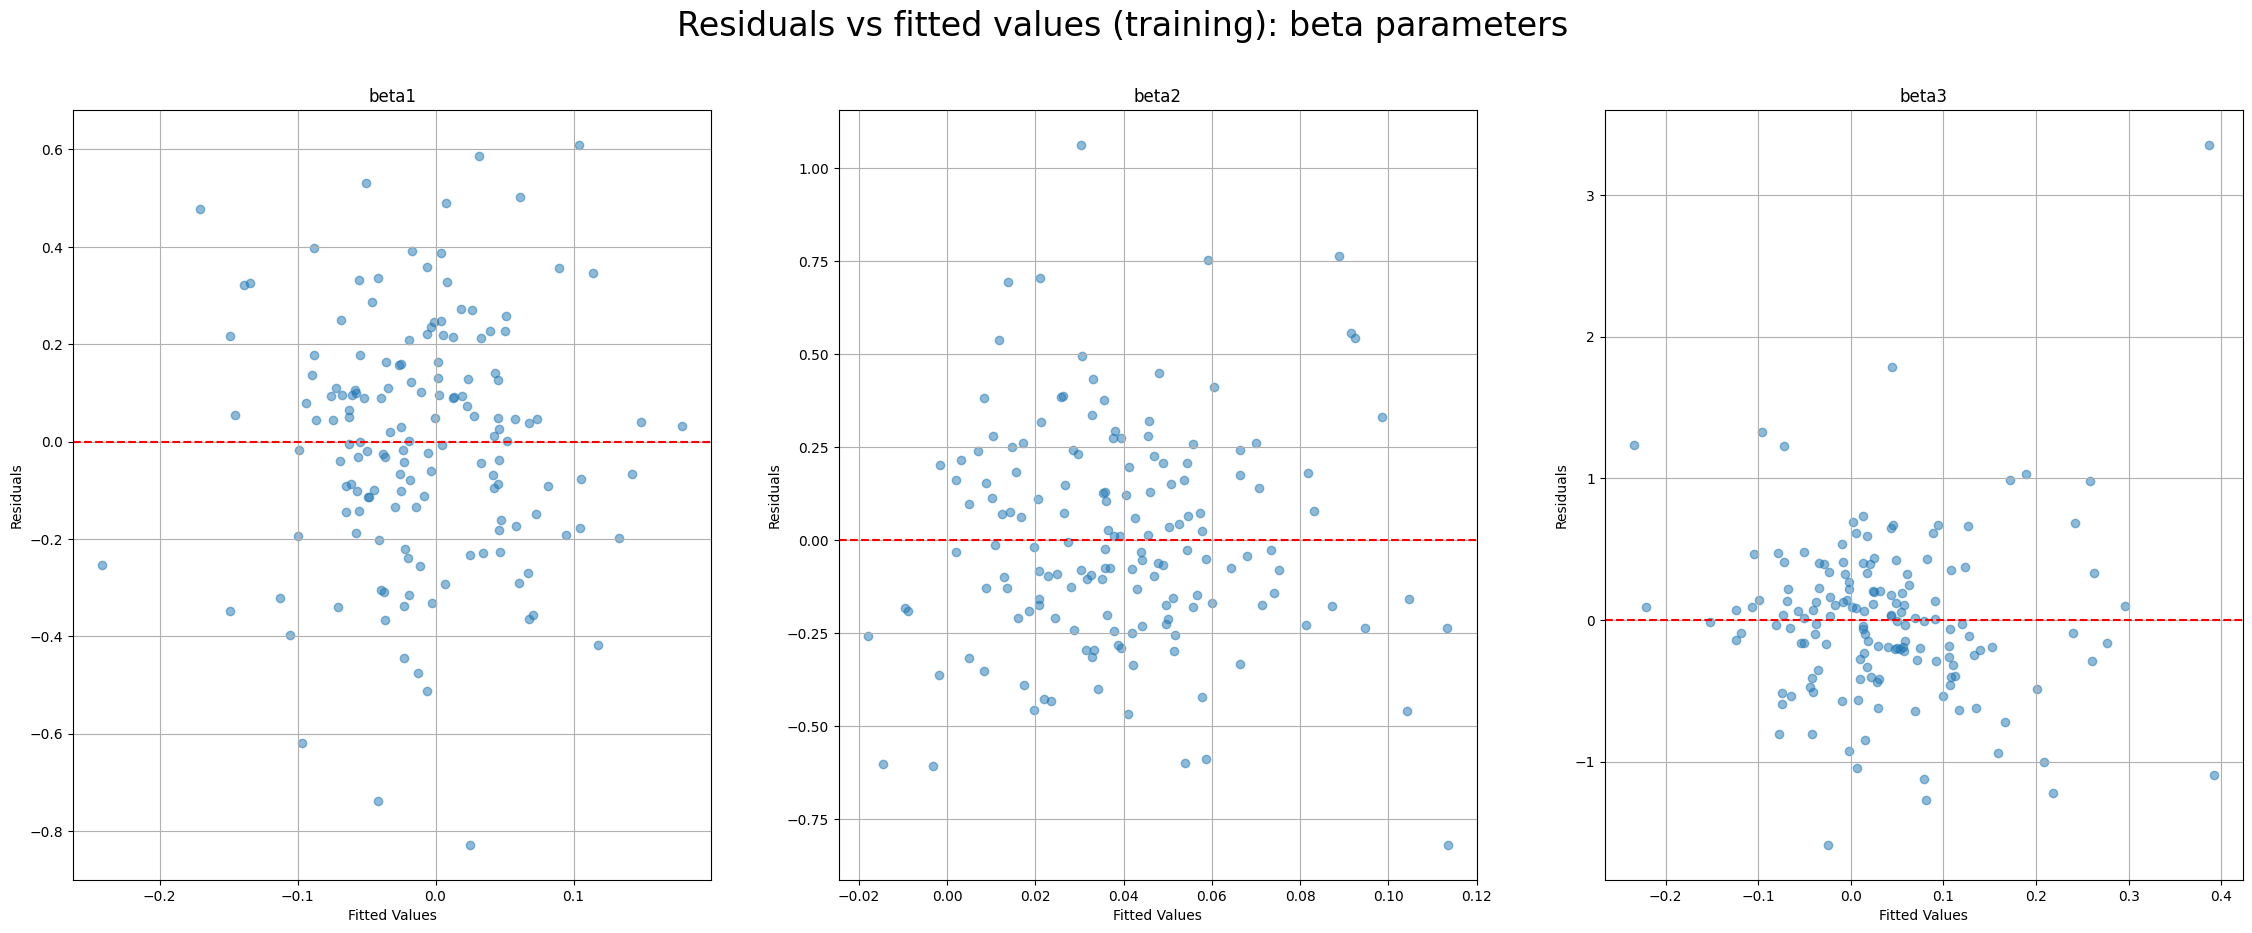

In [30]:
n = len(beta_cols)

fig, axs = plt.subplots(math.ceil(n/3), 3, figsize=(28, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Residuals vs fitted values (training): beta parameters', fontsize=24)

cols = yc.columns
for i, c in enumerate(beta_cols):
    curr_result = train_res_B[i]
    plot_resid_vs_fitted(axs[i%3], curr_result, c)

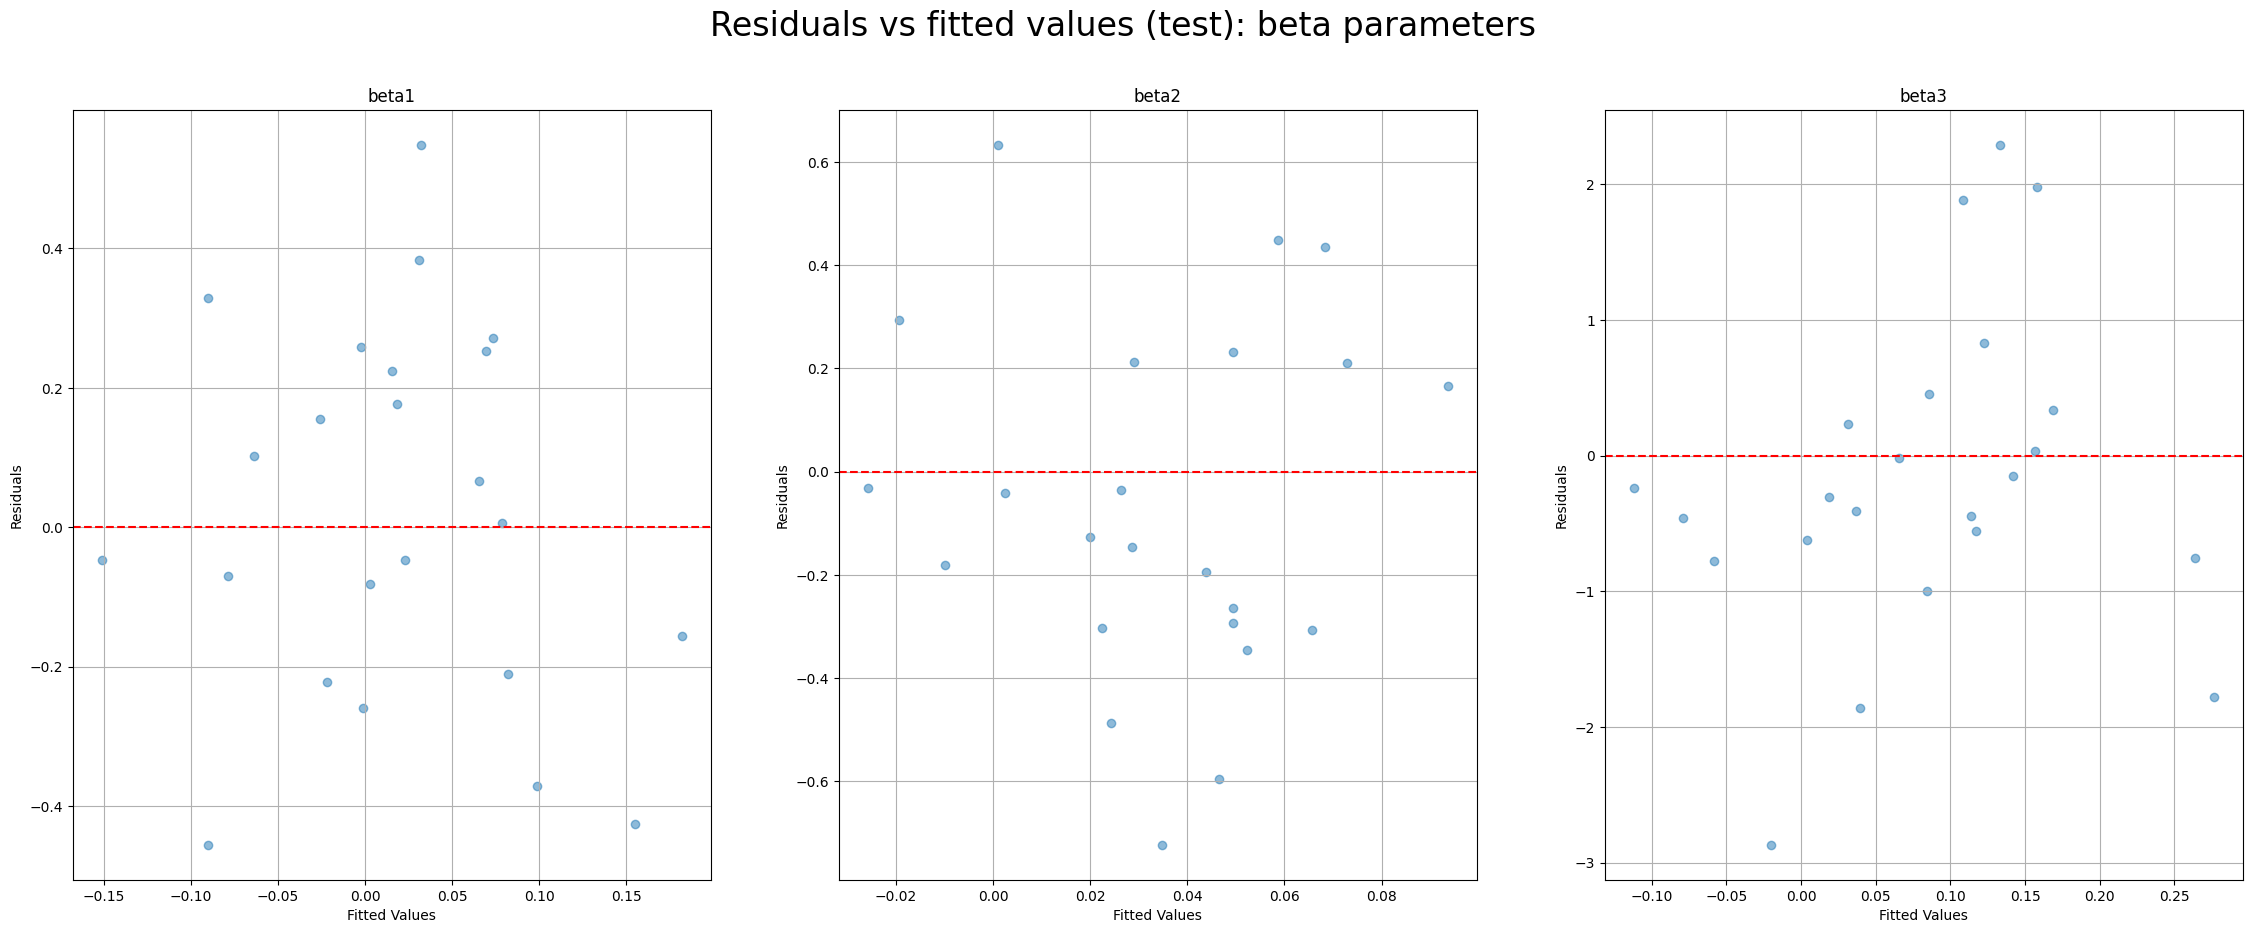

In [31]:
n = len(beta_cols)

fig, axs = plt.subplots(math.ceil(n/3), 3, figsize=(28, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.suptitle('Residuals vs fitted values (test): beta parameters', fontsize=24)

cols = yc.columns
for i, c in enumerate(beta_cols):
    curr_result = results_B[i]
    plot_resid_vs_fitted(axs[i%3], curr_result, c)

#### Interpretation

In general, the residual vs fitted values on training do not exhibit any particularly strong patterns, suggesting that linear regression is an appropriate rough approximation of the relationship between features and responses. Additionally, the patterns exhibited in training and test are not too different, suggesting the model did not overfit. One note:

- Lower maturities seem to have more outliers than higher ones. This makes sense, since the variance of short-term rate changes is higher than long-term rate changes (since long-term rates are closely related to the average of short-term rates over that period)

In [32]:
print(f"OLS train summary for NS parameter 1: level")
summaries_B[0]

OLS train summary for NS parameter 1: level


Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
const   -0.052109  0.026699 -1.951709  0.052836 -0.104863  0.000646
PCEPI    0.239047  0.095983  2.490529  0.013845  0.049395  0.428700
UMCSENT  0.012286  0.005351  2.296003  0.023061  0.001713  0.022859
UNRATE   0.028505  0.025434  1.120765  0.264179 -0.021749  0.078760

In [33]:
print(f"OLS train summary for NS parameter 2: slope")
summaries_B[1]

OLS train summary for NS parameter 2: slope


Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
const    0.039778  0.031835  1.249497  0.213430 -0.023125  0.102681
PCEPI   -0.007121  0.114447 -0.062223  0.950468 -0.233257  0.219015
UMCSENT -0.006762  0.006380 -1.059748  0.290963 -0.019369  0.005845
UNRATE  -0.009736  0.030326 -0.321038  0.748629 -0.069658  0.050186

In [34]:
print(f"OLS train summary for NS parameter 3: twist")
summaries_B[2]

OLS train summary for NS parameter 3: twist


Coef.  Std.Err.         t     P>|t|    [0.025    0.975]
const   -0.046209  0.062384 -0.740729  0.460016 -0.169474  0.077055
PCEPI    0.465235  0.224270  2.074446  0.039747  0.022100  0.908370
UMCSENT  0.008155  0.012503  0.652266  0.515228 -0.016549  0.032860
UNRATE   0.048126  0.059427  0.809833  0.419319 -0.069297  0.165549

#### Interpretation

Macro predictors seem to have meaningful explanatory power for change in level, but not change in slope and twist

### Part 4: Compare model net MAE

For both approaches, we will compare the predicted change in the yield of each maturity vs the actual change.

- Yield curve model: Very straightforward
- Nelson Siegel model: Would need to transform back into "yield curve land" and see what change it predicted

Only via this method can we compare "apples to apples", the accuracy of the predicted change of each maturity

In [35]:
# Step 1: Compute predicted betas from diff

true_beta_values = betas[betas.index >= test_cutoff_date]
true_beta_values.columns = ['beta1_true', 'beta2_true', 'beta3_true']

predicted_betas = true_beta_values + all_preds_B.values
predicted_betas.index = predicted_betas.index + pd.DateOffset(months=1)
predicted_betas.columns = ['beta1_pred', 'beta2_pred', 'beta3_pred']
predicted_betas = predicted_betas.iloc[:-1]

true_beta_values = true_beta_values.iloc[1:]

assert (true_beta_values.index == predicted_betas.index).all(), "True and predicted beta values do not have same dates/dimension"
# assert ((all_preds_B.iloc[1:].values + true_beta_values.shift(1).iloc[1:].values) == predicted_betas.iloc[1:].values).all(), "Incorrect calculation"

#### Transform betas into yield curve values

In [36]:
def beta_to_yield(betas, tau, lam):
    beta1, beta2, beta3 = betas

    return beta1 + (beta2 * term2(tau, lam)) + (beta3 * term3(tau, lam))

def beta_to_yield_curve(betas, taus, lam = 1.6729):
    res = [beta_to_yield(betas, T, lam) for T in taus]
    return res


In [37]:
true_yield_curves = yield_curves[yield_curves.index >= test_cutoff_date]
true_yield_curves = true_yield_curves.iloc[1:]

ns_pred_yield_curves = predicted_betas.apply(lambda row: beta_to_yield_curve(row, T), axis=1, result_type='expand')
ns_pred_yield_curves.columns = maturities

assert (ns_pred_yield_curves.index == true_yield_curves.index).all(), "predicted and true yield curve indices don't match"
assert (ns_pred_yield_curves.columns == true_yield_curves.columns).all(), "predicted and true yield curve columns don't match"

In [38]:
ns_yc_residuals = true_yield_curves - ns_pred_yield_curves
ns_yc_residuals['total_abs_error'] = ns_yc_residuals.abs().sum(axis=1)

In [39]:
yc_total_abs_errors = all_residuals_yc.total_abs_error
ns_total_abs_errors = ns_yc_residuals.total_abs_error

yc_net_mae = yc_total_abs_errors.mean()
ns_net_mae = ns_total_abs_errors.mean()

#### Quick glance at residuals

In [40]:
all_residuals_yc.head(3)

1 Mo      3 Mo      6 Mo      1 Yr      2 Yr      3 Yr  \
Date                                                                     
2023-01-01  0.252768 -0.041174 -0.176642 -0.268500 -0.527862 -0.661761   
2023-02-01 -0.015518  0.140994  0.296720  0.281056  0.679930  0.736253   
2023-03-01  0.054403  0.015800 -0.312657 -0.445189 -0.889451 -0.829077   

                5 Yr      7 Yr     10 Yr     30 Yr  total_abs_error  
Date                                                                 
2023-01-01 -0.699838 -0.687825 -0.608918 -0.485877         4.411165  
2023-02-01  0.666974  0.625596  0.517221  0.346036         4.306298  
2023-03-01 -0.675144 -0.610720 -0.503390 -0.270945         4.606777

In [41]:
ns_yc_residuals.head(3)

1 Mo      3 Mo      6 Mo      1 Yr      2 Yr      3 Yr  \
Date                                                                     
2023-02-01 -0.102327 -0.034037  0.099030 -0.009453 -0.501577 -0.748103   
2023-03-01 -0.265977  0.063381  0.497794  0.581827  0.727124  0.646753   
2023-04-01 -0.231959 -0.028689 -0.036976 -0.275227 -0.781993 -0.884133   

                5 Yr      7 Yr     10 Yr     30 Yr  total_abs_error  
Date                                                                 
2023-02-01 -0.846647 -0.769247 -0.686051 -0.307216         4.103688  
2023-03-01  0.524439  0.529382  0.447240  0.523298         4.807215  
2023-04-01 -0.849611 -0.711112 -0.589833 -0.076837         4.466370

#### Statistical test

In [42]:
t_stat, p_value = stats.ttest_ind(yc_total_abs_errors, ns_total_abs_errors, equal_var=False)  

print(f"Mean total abs error for direct OLS: {yc_net_mae:.3f}")
print(f"Mean total abs error for Nelson Siegel OLS: {ns_net_mae:.3f}\n")

print(f"2-sample t-stat: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Mean total abs error for direct OLS: 2.197
Mean total abs error for Nelson Siegel OLS: 2.420

2-sample t-stat: -0.5620
P-value: 0.5769


#### Interpretation

Although the yield curve error metric is slightly less than the Nelson siegel one, we do not have enough statistical evidence to reject the null hypothesis that they have the same mean total abs error (likely due to limited test sample size/statistical power) 

### Part 5: Qualitative visuals

What constitutes a good yield curve prediction?

- The level or values closely match 
- The shape closely matches

We compare the following:
- predicted_yield_curves_ols: prediction using OLS on each individual maturity
- ns_pred_yield_curves: using OLS on the 3 Nelson siegel params then transforming back to yield curves
- true_yield_curves: the true values of yield curve


In [43]:
true_yield_curves = yield_curves[yield_curves.index >= test_cutoff_date]

predicted_yield_curves_ols = true_yield_curves + all_preds_yc.values
predicted_yield_curves_ols.index = predicted_yield_curves_ols.index + pd.DateOffset(months=1)
predicted_yield_curves_ols = predicted_yield_curves_ols.iloc[:-1]

true_yield_curves = true_yield_curves.iloc[1:]

In [44]:
assert (true_yield_curves.index == predicted_yield_curves_ols.index).all(), "Index not matching"
assert (true_yield_curves.index == ns_pred_yield_curves.index).all(), "Index not matching"

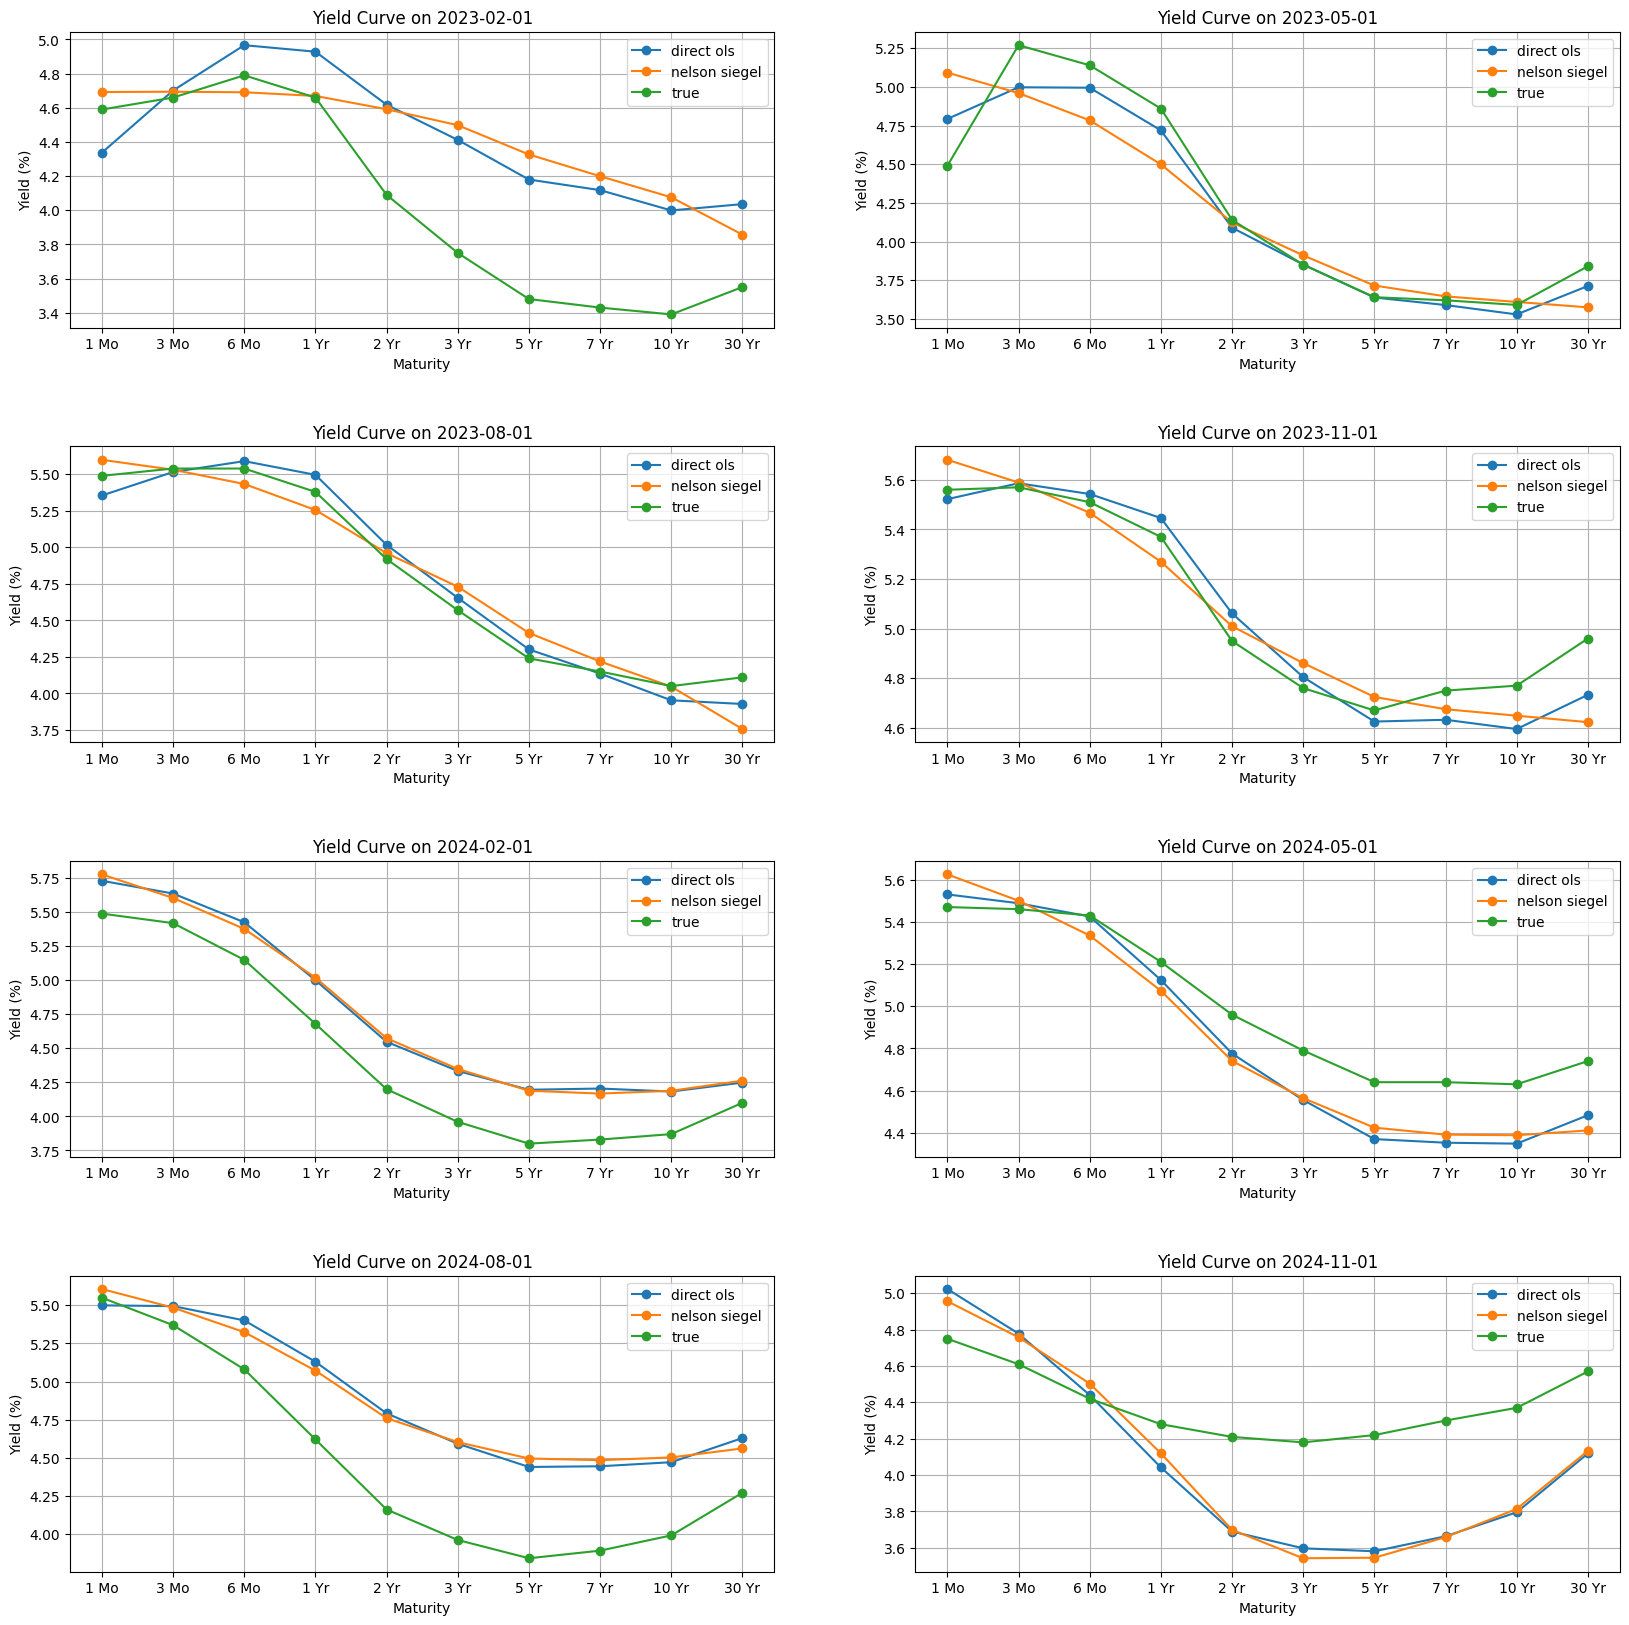

In [45]:
def compare_yield_curves(ax, df1, df2, df3, i):
    ols_row = df1.iloc[i]  
    ns_row = df2.iloc[i] 
    true_row =  df3.iloc[i]

    ax.plot(maturities, ols_row, marker='o', linestyle='-', label = "direct ols")
    ax.plot(maturities, ns_row, marker='o', linestyle='-', label = "nelson siegel")
    ax.plot(maturities, true_row, marker='o', linestyle='-', label = 'true')

    # Formatting
    ax.set_xlabel("Maturity")
    ax.set_ylabel("Yield (%)")
    ax.set_title(f"Yield Curve on {true_yield_curves.index[i].date()}")
    ax.grid(True)
    ax.legend()

fig, axs = plt.subplots(4,2, figsize=(20, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

compare_yield_curves(axs[0, 0], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 0)
compare_yield_curves(axs[0, 1], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 3)
compare_yield_curves(axs[1, 0], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 6)
compare_yield_curves(axs[1, 1], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 9)
compare_yield_curves(axs[2, 0], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 12)
compare_yield_curves(axs[2, 1], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 15)
compare_yield_curves(axs[3, 0], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 18)
compare_yield_curves(axs[3, 1], predicted_yield_curves_ols, ns_pred_yield_curves, true_yield_curves, 21)

#### Observations

- Nelson siegel (orange) curves are generally flatter than the direct OLS predictions (less variance in shape)
- It is not visually obvious which one has more accurate predictions

Both seem to be particularly bad at predicting changes in long-term yields. This makes sense, as there is much more information that goes into long-term rates than simply looking at the 1-month change in inflation/consumer sentiment. Long-term rates consist of all available information on economic policy forecasts for the next 5-10 years. Just because inflation went up 0.6% last month doesn't mean we expect that to continue happening over the next 10 years.

### Concluding Thoughts

Overall, there was a *lack of statistical evidence to suggest there is a meaningful difference in predictive accuracy between directly performing OLS on the yield curve itself vs. its Nelson Siegel parameters*. This conclusion is made under the context of using 1-month change in inflation, consumer sentiment, and unemployment to predict next-month yield curve changes. </br>

The *main weakness of the OLS on Nelson Siegel method is that the features did not have meaningful predictive power on the shape of the yield curve* - only its value. Without features that can predict the shape/structure of the yield curve, the model loses its power. In that case, we might as well perform OLS directly on the yield curve itself, since at least we get a more precise prediction of the level of each maturity (rather than a single $\beta_1$ feature representing the average level of the entire curve) 

Therefore, to *capture the benefits of Nelson Siegel parametrization, we would need to find features that capture the change in steepness/curvature of the yield curve*, which necessarily requires features that capture long-term economic expectations (rather than 1m backward-looking changes). 